In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from scipy.stats import entropy

In [2]:
# Load the data
df_pbs = pd.read_csv('../pbs_c/cmake-build-debug/pbsBlocks.csv')
df_cmp = pd.read_csv('../pbs_c/cmake-build-debug/comparison.csv')

In [3]:
df_pbs.describe()

,Block Number,Proposer ID,Builder ID,Winning Bid Value,Winning Block Value,Reward,Builder ID 1 Bid,Builder ID 2 Bid,Builder ID 3 Bid,Builder ID 4 Bid,...,Builder ID 1 Block Value,Builder ID 2 Block Value,Builder ID 3 Block Value,Builder ID 4 Block Value,Builder ID 5 Block Value,Builder ID 10 Block Value,Builder ID 30 Block Value,Builder ID 50 Block Value,Builder ID 70 Block Value,Builder ID 90 Block Value
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,26.442800,30.717400,261.958600,487.242578,225.283978,215.711800,215.770600,216.093800,216.368100,...,411.730704,410.533991,411.391270,410.142468,411.722712,504.942603,509.006502,510.920505,496.886093,511.572565
std,1443.520003,30.844581,31.911315,77.604779,137.895639,94.804875,100.712806,100.391823,100.109165,99.707536,...,170.454647,171.178006,170.222563,169.606177,168.978647,157.407175,157.336496,153.486172,163.178795,153.284423
min,1.000000,1.000000,1.000000,0.000000,41.147100,18.147100,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.750000,3.000000,3.000000,208.000000,395.720500,154.828250,139.000000,139.000000,139.000000,140.875000,...,302.547750,299.078750,300.363250,299.318250,301.997500,419.480750,427.144000,428.574250,406.116000,430.594500
50%,2500.500000,10.000000,10.000000,282.500000,484.972000,211.627000,229.000000,227.750000,228.500000,228.500000,...,418.646500,416.071000,417.625500,415.546000,416.140500,522.189000,526.931500,527.586000,516.193000,527.007500
75%,3750.250000,50.000000,50.000000,324.500000,578.858750,282.902750,304.500000,304.125000,304.000000,304.000000,...,525.729750,524.079000,524.136250,522.529500,523.850250,609.674000,613.962500,612.475500,606.503250,613.567500
max,5000.000000,90.000000,90.000000,667.500000,1027.060000,715.057000,667.000000,667.000000,667.000000,667.000000,...,926.404000,932.852000,903.452000,933.325000,926.404000,1006.530000,1027.060000,1006.030000,1006.960000,1014.510000


In [4]:
def get_builder_type(id):
    if 1 <= id <= 9:
        return 'Normal Proposer Builder'
    elif 10 <= id <= 999:
        return 'MEV Proposer Builder'
    else:
        return 'Unknown Builder'

def adjust_builder_id(id):
    if(get_builder_type(id) == 'MEV Proposer Builder'):
        return int(int(id) / 20 + 1)
    else:
        return id

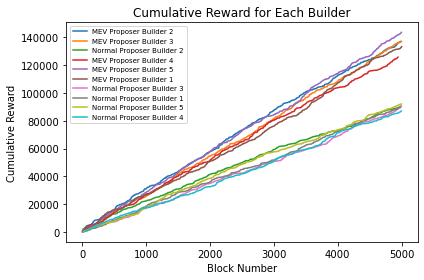

In [5]:
builder_ids = df_pbs['Builder ID'].unique()
fig, axs = plt.subplots()
for builder_id in builder_ids:
    builder_df_pbs = df_pbs[df_pbs['Builder ID'] == builder_id]
    cumulative_rewards = np.cumsum([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    axs.plot(builder_df_pbs['Block Number'].values, cumulative_rewards, label=f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}')

axs.set_title('Cumulative Reward for Each Builder')
axs.set_xlabel('Block Number')
axs.set_ylabel('Cumulative Reward')
axs.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()

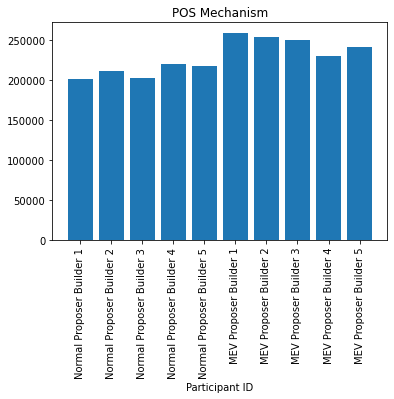

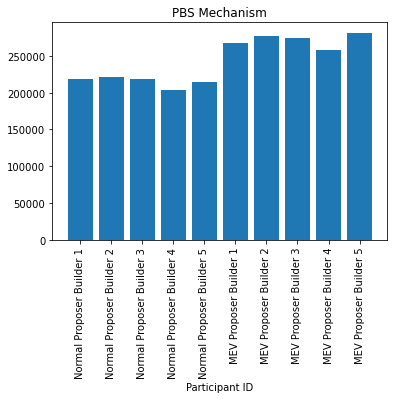

In [6]:
total_rewards_pos = []
total_rewards_pbs = []
builder_ids = np.sort(df_pbs['Builder ID'].unique())

for builder_id in builder_ids:
    cumulative_rewards_pbs = ([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id]+
                                    [bid for bid, id in zip(df_pbs['Winning Bid Value'], df_pbs['Proposer ID']) if id == builder_id])
    total_rewards_pbs.append(sum(cumulative_rewards_pbs))

    cumulative_rewards_pos = [reward for reward, id in zip(df_cmp['POS Block Value'], df_cmp['POS Builder ID']) if id == builder_id]
    total_rewards_pos.append(sum(cumulative_rewards_pos))


builder_ids = [f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}' for builder_id in builder_ids]
plt.bar(builder_ids, total_rewards_pos)
plt.title('POS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()

plt.bar(builder_ids, total_rewards_pbs)
plt.title('PBS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()



In [7]:
def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [8]:
gini_pbs = gini(np.array(total_rewards_pbs))
gini_pos = gini(np.array(total_rewards_pos))

print(f'Gini coefficient for PBS rewards: {gini_pbs}')
print(f'Gini coefficient for POS rewards: {gini_pos}')

Gini coefficient for PBS rewards: 0.06634845095052742
Gini coefficient for POS rewards: 0.0505063851471397


In [9]:
# Herfindahl-Hirschman Index (HHI) 
def hhi(x):
    """Compute Herfindahl-Hirschman Index of array of values"""
    return (x**2).sum() / (x.sum())**2

hhi_pos = hhi(np.array(total_rewards_pos))
hhi_pbs = hhi(np.array(total_rewards_pbs))

print(f"HHI for PBS: {hhi_pbs}")
print(f"HHI for POS: {hhi_pos}")

HHI for PBS: 0.10145162703992962
HHI for POS: 0.10078937983452949
